In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pyarrow as pa
import pyarrow.parquet as pq
import glob
import warnings
warnings.filterwarnings('ignore')

In [12]:
train = pd.read_csv('/Users/ericp/OneDrive/Documents/GitHub/Optiver/train.csv')
test = pd.read_csv('/Users/ericp/OneDrive/Documents/GitHub/Optiver/test.csv')
order_book = pq.read_table('/Users/ericp/OneDrive/Documents/GitHub/Optiver/book_train.parquet/stock_id=0/').to_pandas()
trade_book = pq.read_table('/Users/ericp/OneDrive/Documents/GitHub/Optiver/trade_train.parquet/stock_id=0/').to_pandas()

In [13]:
order_book_train = glob.glob('/Users/ericp/OneDrive/Documents/GitHub/Optiver/book_train.parquet/*')
trade_book_train = glob.glob('/Users/ericp/OneDrive/Documents/GitHub/Optiver/trade_train.parquet/*')

In [14]:
order_book = order_book[order_book['time_id'] == 5]
order_book['stock_id'] = 0
trade_book = trade_book[trade_book['time_id'] == 5]
trade_book['stock_id'] = 0

In [15]:
print('train has {} rows and {} columns'.format(train.shape[0],train.shape[1]))
print('test has {} rows and {} columns'.format(test.shape[0], test.shape[1]))
print('order_book has {} rows and {} columns'.format(order_book.shape[0], order_book.shape[1]))
print('trade_book has {} rows and {} columns'.format(trade_book.shape[0], trade_book.shape[1]))

train has 428932 rows and 3 columns
test has 3 rows and 3 columns
order_book has 302 rows and 11 columns
trade_book has 40 rows and 6 columns


In [8]:
train.head()

,stock_id,time_id,target
0,0,5,0.004136
1,0,11,0.001445
2,0,16,0.002168
3,0,31,0.002195
4,0,62,0.001747


In [9]:
test.head()

,stock_id,time_id,row_id
0,0,4,0-4
1,0,32,0-32
2,0,34,0-34


In [16]:
order_book.head()

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2,stock_id
0,5,0,1.001422,1.002301,1.00137,1.002353,3,226,2,100,0
1,5,1,1.001422,1.002301,1.00137,1.002353,3,100,2,100,0
2,5,5,1.001422,1.002301,1.00137,1.002405,3,100,2,100,0
3,5,6,1.001422,1.002301,1.00137,1.002405,3,126,2,100,0
4,5,7,1.001422,1.002301,1.00137,1.002405,3,126,2,100,0


In [17]:
trade_book.head()

,time_id,seconds_in_bucket,price,size,order_count,stock_id
0,5,21,1.002301,326,12,0
1,5,46,1.002778,128,4,0
2,5,50,1.002818,55,1,0
3,5,57,1.003155,121,5,0
4,5,68,1.003646,4,1,0


In [18]:
order_book['wt_avg'] = (order_book['bid_price1'] * order_book['ask_size1'] + order_book['ask_price1'] * 
                        order_book['bid_size1']) / (order_book['bid_size1'] + order_book['ask_size1'])

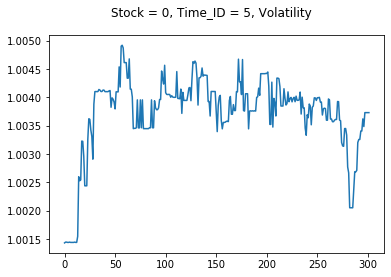

In [20]:
fig,axs = plt.subplots(1)
fig.suptitle('Stock = 0, Time_ID = 5, Volatility')
axs.plot(order_book['wt_avg'])

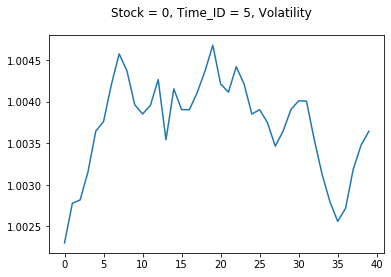

In [21]:
fig,axs = plt.subplots(1)
fig.suptitle('Stock = 0, Time_ID = 5, Volatility')
axs.plot(trade_book['price'])

In [22]:
def logDiff(stock_prices):
    return np.log(stock_prices).diff()

In [25]:
order_book['logDifferences'] = logDiff(order_book['wt_avg'])
order_book = order_book[order_book['logDifferences'].notnull()]
trade_book['logDifferences'] = logDiff(trade_book['price'])
trade_book = trade_book[trade_book['logDifferences'].notnull()]

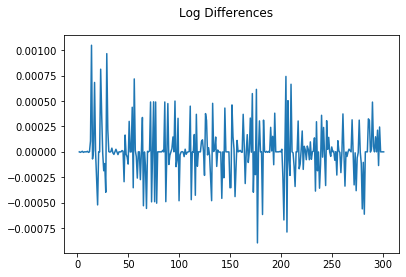

In [26]:
fig, axs = plt.subplots(1)
fig.suptitle('Log Differences')
axs.plot(order_book['logDifferences'])

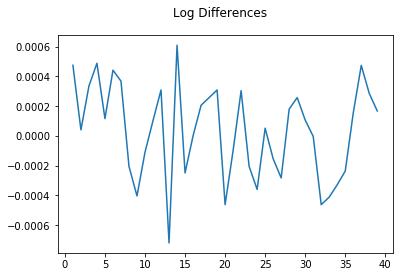

In [27]:
fig, axs = plt.subplots(1)
fig.suptitle('Log Differences')
axs.plot(trade_book['logDifferences'])

In [28]:
def realized_vol(log_diffs):
    return np.sqrt(np.sum(log_diffs ** 2))

In [29]:
print('Realized vol for Stock 0 over Time Period 5 order_book is: {}'.format(realized_vol(order_book['logDifferences'])))
print('Realized vol for Stock 0 over Time Period 5 trade_book is: {}0'.format(realized_vol(trade_book['logDifferences'])))

Realized vol for Stock 0 over Time Period 5 order_book is: 0.004499342176374144
Realized vol for Stock 0 over Time Period 5 trade_book is: 0.00200588954612612720


In [31]:
def RMSPE(vols):         
    return np.sqrt((np.sum(vols[0] - vols.iloc[1] ** 2)) / len(vols))    

In [32]:
PATH = glob.glob('/Users/ericp/OneDrive/Documents/GitHub/Optiver/book_train.parquet/*')

In [37]:
def orderBookVol(path):
    realized_vols = []
    order_book = pq.read_table(path).to_pandas()
    x = int(path.split('=')[1])
    order_book['stock_id'] = x
    order_book['row_id'] = str(order_book['stock_id']) + ('-') + order_book['time_id']
    order_book['wt_avg'] = (order_book['bid_price1'] * order_book['ask_size1'] + order_book['ask_price1'] * 
                        order_book['bid_size1']) / (order_book['bid_size1'] + order_book['ask_size1'])
    order_book['logDifferences'] = order_book.groupby('time_id')['wt_avg'].apply(logDiff)
    order_book = order_book[order_book['logDifferences'].notnull()]
    realized_vols.append(order_book.groupby('time_id')['logDifferences'].apply(realized_vol))
    realized_vols = pd.Series(realized_vols)
    realized_vols = pd.DataFrame(order_book['row_id'], realized_vols, columns = ['row_id', 'target'])
    return realized_vols    

In [60]:
order_book['stock_id'] = x 

In [ ]:
for file in files:
    orderBookVol(file)

In [62]:
  order_book['row_id'] = str(order_book['stock_id']) + ('-') + str(order_book['time_id'])

In [63]:
order_book.head()

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2,stock_id,row_id
0,5,0,1.001422,1.002301,1.00137,1.002353,3,226,2,100,0,0 0\n1 0\n2 0\n3 ...
1,5,1,1.001422,1.002301,1.00137,1.002353,3,100,2,100,0,0 0\n1 0\n2 0\n3 ...
2,5,5,1.001422,1.002301,1.00137,1.002405,3,100,2,100,0,0 0\n1 0\n2 0\n3 ...
3,5,6,1.001422,1.002301,1.00137,1.002405,3,126,2,100,0,0 0\n1 0\n2 0\n3 ...
4,5,7,1.001422,1.002301,1.00137,1.002405,3,126,2,100,0,0 0\n1 0\n2 0\n3 ...
